# Predicting Past Tense Forms of English Verbs
'Recreating' the paper: insert paper here  
Changes we made to the original model:
  * We use raw letters, rather than wicklefeatures  
  * RelU units as intermediates, rather than sigmoids  


In [1]:
%matplotlib inline
# %pylab inline
# %logstart tmp/session2.log

In [2]:
import numpy as np
import theano
import theano.tensor as T
import random
import lasagne
import warnings
import matplotlib.pyplot as plt
from IPython import display
warnings.filterwarnings('ignore', module='lasagne')

epochs = 500

in_layer = lasagne.layers.InputLayer(shape=(None, 19, 27)) # Arbitrary number of examples, 19 letters, 27 possibilities
H1_layer = lasagne.layers.DenseLayer(in_layer, 200, nonlinearity = lasagne.nonlinearities.rectify)
H2_layer = lasagne.layers.DenseLayer(H1_layer, 200, nonlinearity = lasagne.nonlinearities.rectify)
net = lasagne.layers.DenseLayer(H2_layer, 513, nonlinearity = lasagne.nonlinearities.sigmoid)

# Generate some data
net_output = lasagne.layers.get_output(net)
# As a loss function, we'll use Theano's squared error function.
true_output = T.ivector('true_output')
loss = T.mean(lasagne.objectives.squared_error(net_output, true_output))

# Retrieving all parameters of the network is done using get_all_params,
# which recursively collects the parameters of all layers connected to the provided layer.
all_params = lasagne.layers.get_all_params(net)
# Now, we'll generate updates using Lasagne's SGD function
updates = lasagne.updates.nesterov_momentum(loss, all_params, learning_rate=0.2, momentum=0.9) 
# Finally, we can compile Theano functions for training and computing the output.
# Note that because loss depends on the input variable of our input layer,
# we need to retrieve it and tell Theano to use it.
train = theano.function([in_layer.input_var, true_output], loss, updates=updates, allow_input_downcast=True)
get_output = theano.function([in_layer.input_var], net_output)

def wordToVec(word):
    ''' convert the word to a one-of-n feature vector'''
    vec = []

    for letter in word:
        subvec = []
        for k in range(27):
            if ord(letter)-96 == k:
                subvec.append(1)
            else:
                subvec.append(0)
        vec.append(subvec)

    #Fill in the rest of the empty letters
    for k in range(19-len(word)):
        subvec = [1]
        for k in range(26):
            subvec.append(0)
        vec.append(subvec)
    return vec

def vecToWord(vec):
    word = ''
    for k in range(19):
        for i in range(27):
            if vec[k*27 + i] == 1:
                word = word + chr(i+96)
                break
    return word

def thresh(vec):
    vec2 = []
    for item in vec:
        if item > 0.5:
            vec2.append(1)
        else:
            vec2.append(0)
    return vec2

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)

        yield inputs[excerpt], targets[excerpt]
        
errors = []
def measureError():
    error = 0
    for index in range(len(X)):
        if vecToWord(thresh(Y[index])) != vecToWord(thresh(get_output([X[index]])[0])):
            error +=1
    return error


def plotError():
    xaxis = range(len(errors))
    for index in range(len(xaxis)):
        xaxis[index] = xaxis[index] * 25
    plt.plot(xaxis, errors)
    display.clear_output(wait=True)
    display.display(plt.gcf())

datafile = open('chosenWords2.txt')
X = []
Y = []

while True:
    line = datafile.readline()
    if line=='':		# EOF
        break
    base, future = line.split(',')
    if future == '':	# There were some problems with the library
        continue
    future = future[:-1] # Remove the newline
    X.append(np.array(wordToVec(base), theano.config.floatX))
    Y.append(np.array(sum(wordToVec(future),[]), theano.config.floatX))


X = np.array(X, theano.config.floatX)
Y = np.array(Y, theano.config.floatX)

# train([wordToVec('yell')],sum(wordToVec('yelled'),[]))

# for epic in range(epochs):
# 	if epic%25 == 0:
# 		print epic
# 	for index in range(len(X)):
# 		train([X[index]],Y[index])



# for epic in range(epochs):
# 	if epic%25 ==0: print epic
# 	for batch in iterate_minibatches(X, Y, len(X), shuffle=True):
# 	        inputs, targets = batch
# 	        # print len(inputs), len(targets)
# 	        train(inputs, targets)

# for index in range(len(X)):
# 	(get_output([wordToVec(X[index])],sum(wordToVec(Y[index]),[]))
# print vecToWord(thresh(get_output([wordToVec('yell')])[0]))
# print get_output([wordToVec('yell')])

# # Train the network
# for k in range(5): #number of epochs
# 	for k in range(samples):
# 		train([in_data[k]], [out_data[k]])

# # Test our network, overfitting isn't really a problem with 5 total nodes.
# print (get_output([[50,50]])) #Should be around 400
# print(net.W.get_value())


Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN not available)
C:\Users\Natha\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
datafile = open('irregulars.txt')
Z = []
W = []

while True:
	line = datafile.readline()
	if line=='':		# EOF
		break
	base, future = line.split(',')
	if future == '':	# There were some problems with the library
		continue
	future = future[:-1] # Remove the newline
	Z.append(np.array(wordToVec(base), theano.config.floatX))
	W.append(np.array(sum(wordToVec(future),[]), theano.config.floatX))
Z = np.array(Z, theano.config.floatX)
W = np.array(W, theano.config.floatX)

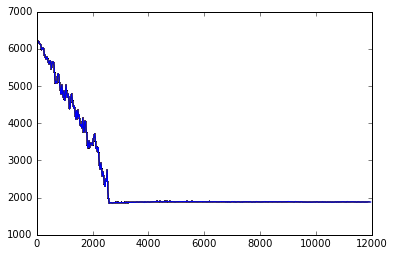

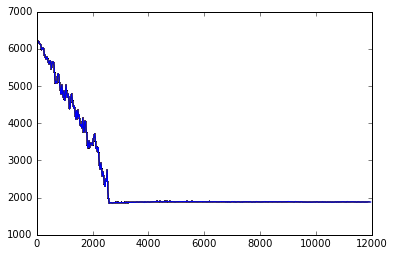

In [7]:
epochs = 10000
for epic in range(epochs):
    if epic%25 == 0:
        print epic
        errors.append(measureError())
        plotError()
    for index in range(int(len(X)*3/4)):
        train([X[index]],Y[index])
    for k in range(8):
        for index in range(len(Z)):
            train([Z[index]],W[index])

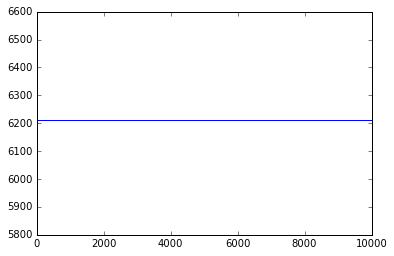

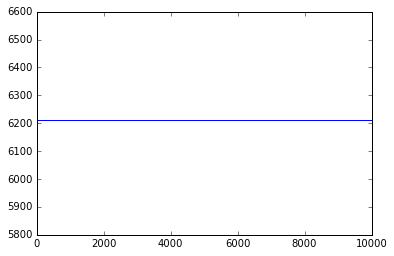

In [3]:
# minibatch doesn't work :(
# epochs = 10000
# for epic in range(epochs):
#     if epic%25 == 0:
#         print epic
#         errors.append(measureError())
#         plotError()
#     for batch in iterate_minibatches(X, Y, len(X), shuffle=True):
#             inputs, targets = batch
#             # print len(inputs), len(targets)
#             train(inputs, targets)

In [ ]:
# out = open("out20k.txt",'w')
# for index in range(len(X)):
#     out.write(vecToWord(thresh(get_output([X[index]])[0])) + "\n")

In [8]:
for index in range(len(Z)):
    print vecToWord(thresh(get_output([X[index]])[0]))

fawned`````````````
convoluted`````````
yellowed```````````
prefied```````````
prefaced```````````
underachieed``````
shambled```````````
conured```````````
rucked`````````````
chattered``````````
solded````````````
quadrupled`````````
outitted``````````
tingled````````````
sputtered``````````
lorded`````````````
anteceded``````````
swiveled```````````
bellyached`````````
stipulated`````````
befouled```````````
fouled`````````````
disturbed``````````
prized`````````````
buttonholed````````
understoced```````
disburdened````````
frittered``````````
orientated`````````
chartered``````````
tolerated``````````
pulsed`````````````
seconed```````````
tethered```````````
intermingled```````
thundered``````````
boogied````````````
decried````````````
succumbed``````````
culled`````````````
crouched```````````
averted````````````
splintered`````````
herded`````````````
chined`````````````
shrieked```````````
chinked````````````
elaborated`````````
personified````````
conglutinated``````
exuviat

In [ ]:
print len(X)

In [11]:
plotError()

In [ ]:
wow = [[1,2], [3,4]]
sum(wow,[])
